In [1]:
import numpy as np
import nltk
import glob
import os
from sklearn.feature_extraction.text import CountVectorizer
from scipy.cluster.vq import whiten
from sklearn.metrics import accuracy_score,precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.cross_validation import KFold


In [3]:

#preparing and loading data
def GetData(path):
   
    files = sorted(glob.glob(os.path.join(path, "*.txt")))
    books = []
    y=[]
    for fn in files:
        y.append(fn.split("\\")[4].split("_")[0])
        with open(fn) as f:
            books.append(f.read().replace('\n', ' '))
    all_text = ' '.join(books)
    print len(books)
    y=np.array(y)
    return y,books,all_text
    

y,books,all_text=GetData(r"C:\data\MS\yewno")

40


In [4]:
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
word_tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
def getSpecifications(text):
   
    tokens = nltk.word_tokenize(text.lower())

    words = word_tokenizer.tokenize(text.lower())
    sentences = sentence_tokenizer.tokenize(text)
    vocab = set(words)

    words_per_sentence = np.array([len(word_tokenizer.tokenize(s))
                                   for s in sentences])


    return tokens,words,sentences,vocab,words_per_sentence

  

In [5]:
#for visualizing tokens, words, sentences, etc
%matplotlib inline
import matplotlib.pyplot as plt

def plotSpecifications(x,color,ylab):
    plt.figure(figsize=(7,7))
    
    width = 0.60   
    ind = np.arange(40)
    p1 = plt.bar(ind, x, width, color=color)
    plt.ylabel(ylab)
    plt.title('Books')
   

    plt.show()
    


In [6]:

def LexicalFeatures(books):
    t=[]
    wps=[]
    s=[]
    unique_words=[]
    fvs_lexical = np.zeros((len(books), 3), np.float64)
    fvs_punct = np.zeros((len(books), 3), np.float64)
    for i, text in enumerate(books):
        print i,
        tokens,words,sentences,vocab,words_per_sentence=getSpecifications(text)
      
        t.append(len(tokens))
        wps.append(len(words_per_sentence))
        s.append(len(sentences))
        unique_words.append(len(vocab))
        
        # average number of words per sentence
        fvs_lexical[i, 0] = words_per_sentence.mean()
        # sentence length variation
        fvs_lexical[i, 1] = words_per_sentence.std()
        # Lexical diversity
        fvs_lexical[i, 2] = len(vocab) / float(len(words))
    
    
        '''punctuation fetaures'''
        # Commas per sentence
        fvs_punct[i, 0] = tokens.count(',') / float(len(sentences))
        # Semicolons per sentence
        fvs_punct[i, 1] = tokens.count(';') / float(len(sentences))
        # Colons per sentence
        fvs_punct[i, 2] = tokens.count(':') / float(len(sentences))
    # apply whitening to decorrelate the features
    #fvs_lexical = whiten(fvs_lexical)
    #fvs_punct = whiten(fvs_punct)
    plotSpecifications(t,color='r',ylab="tokens per book")
    plotSpecifications(s,color='g', ylab= "number of sentences in each book")
    plotSpecifications(wps,color='y', ylab= "words per sentence in each book")
  
    plotSpecifications(unique_words,color='b', ylab="number of unique words in each book")
    merge=np.concatenate([fvs_lexical,fvs_punct],axis=1)
    return merge



In [7]:
def BagOfWords(all_text):
    # get most common words in the whole book
    all_tokens = nltk.word_tokenize(all_text)    
    fdist = nltk.FreqDist(all_tokens)
    vocab = fdist.keys()[:250]
    
    
    vectorizer = CountVectorizer(vocabulary=vocab, tokenizer=nltk.word_tokenize)
    fvs_bow = vectorizer.fit_transform(books).toarray().astype(np.float64)

    # normalization
    fvs_bow /= np.c_[np.apply_along_axis(np.linalg.norm, 1, fvs_bow)]
    return fvs_bow

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39

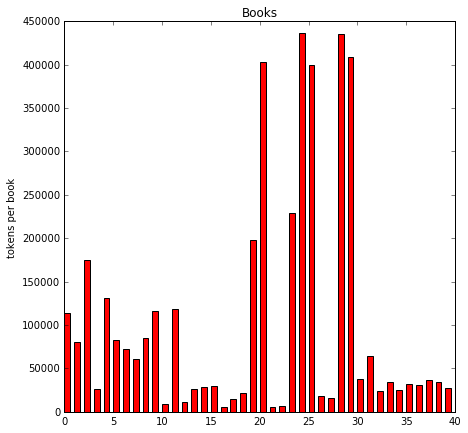

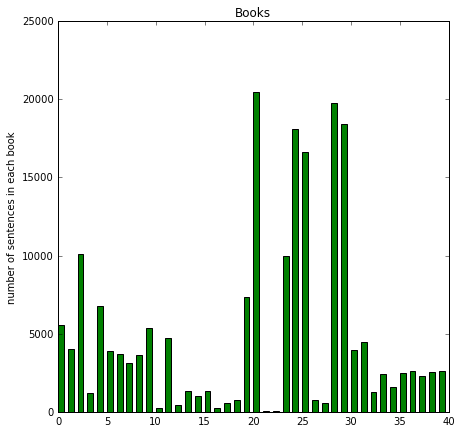

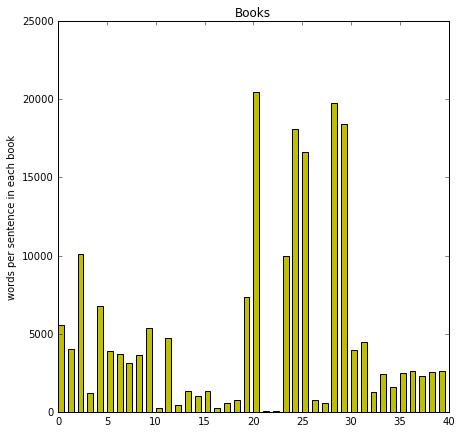

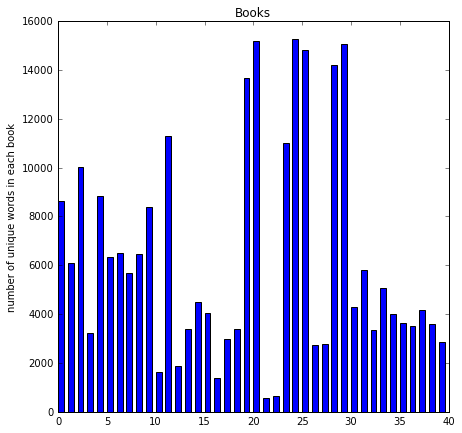

 
done with extracting lexical features
done with extracting bags
(40L, 256L)


In [8]:
lexicals=LexicalFeatures(books)
print "\ndone with extracting lexical features"
bags=BagOfWords(all_text)
print "done with extracting bags"
feature_sets=np.concatenate([lexicals,bags],axis=1)
print feature_sets.shape

In [10]:
print feature_sets

[[ 1.40881351  0.89924476  1.62653062 ...,  0.11228851  0.05587604
   0.04350311]
 [ 1.39012809  0.85152796  1.62089262 ...,  0.10520725  0.04386239
   0.03731427]
 [ 1.16214828  0.73296438  1.2593092  ...,  0.09767357  0.05451163
   0.04196363]
 ..., 
 [ 1.08369442  1.27671475  2.49898536 ...,  0.07717894  0.05146164
   0.02804294]
 [ 0.84925335  1.05735484  2.41965399 ...,  0.06786728  0.06230778
   0.02433759]
 [ 0.67106365  0.71357679  2.37117952 ...,  0.07243147  0.04446178
   0.0318327 ]]


In [9]:


def get_LR_clf():
    
    return LogisticRegression(random_state=np.random.seed(seed=42))
def get_NB_clf():
    
    return GaussianNB()
def get_SVM_clf():
    return svm.LinearSVC()

In [27]:

def do_cross_validation(X, y, model,filename,n_folds=10, verbose=False):
    outf = open(filename, 'wt')
    #model = get_LR_clf()
    model.fit(X, y)
    
    cv = KFold(len(y), n_folds)
    accuracies = []
    precisions=[]
    recalls=[]
    i=0
    outf.write("true labels\t predicted labels\n")
    for train_ind, test_ind in cv:
        i+=1
        outf.write("\nfold k=%d\n"%i)
        model.fit(X[train_ind], y[train_ind])
        predictions = model.predict(X[test_ind])
        
        m=-1
        for j in test_ind:
            m+=1
            outf.write(y[j]+"\t"+predictions[m]+"\n")
            
        accuracies.append(accuracy_score(y[test_ind], predictions))
        precisions.append(precision_score(y[test_ind], predictions,pos_label=None,average='weighted'))
        recalls.append(recall_score(y[test_ind], predictions,pos_label=None,average='weighted'))
    
    return np.mean(accuracies),np.mean(precisions),np.mean(recalls)
    
accuracy,precision,recall=  do_cross_validation(feature_sets, y,model=get_LR_clf(),filename="LogisticRegressionOp.txt")   



In [18]:
print "average accuracy for Logistic Regression=", accuracy
print "average precision for Logistic Regression=", precision
print "average recall for Logistic Regression=", recall


average accuracy for Logistic Regression= 0.55
average precision for Logistic Regression= 0.85
average recall for Logistic Regression= 0.55


In [28]:

accuracy1,precision1,recall1=do_cross_validation(feature_sets, y, model=get_NB_clf(),filename="Naive Bayes Op.txt")
print "average accuracy for Naive Bayes=", accuracy1
print "average precision for Naive Bayes=", precision1
print "average recall for Naive Bayes=", recall1


average accuracy for Naive Bayes= 0.375
average precision for Naive Bayes= 0.658333333333
average recall for Naive Bayes= 0.375


In [29]:

accuracy2,precision2,recall2=do_cross_validation(feature_sets, y, model=get_SVM_clf(), filename="SVM op.txt")
print "average accuracy for Support Vectors=", accuracy2
print "average precision for Support Vectors=", precision2
print "average recall for SUpport Vectors=", recall2

      

average accuracy for Support Vectors= 0.8
average precision for Support Vectors= 1.0
average recall for SUpport Vectors= 0.8
